In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose


In [3]:
# Simulating Sensor Data (Temperature, Pressure, Humidity, Vibration)
n = 1000  # Number of data points
data = {
    'temperature': np.random.normal(loc=25, scale=5, size=n),
    'pressure': np.random.normal(loc=1013, scale=10, size=n),
    'humidity': np.random.normal(loc=60, scale=10, size=n),
    'vibration': np.random.normal(loc=0, scale=1, size=n),
}
df = pd.DataFrame(data)

# Adding timestamp for Time Series Analysis
df['timestamp'] = pd.date_range(start='1/1/2025', periods=n, freq='h')
df.set_index('timestamp', inplace=True)


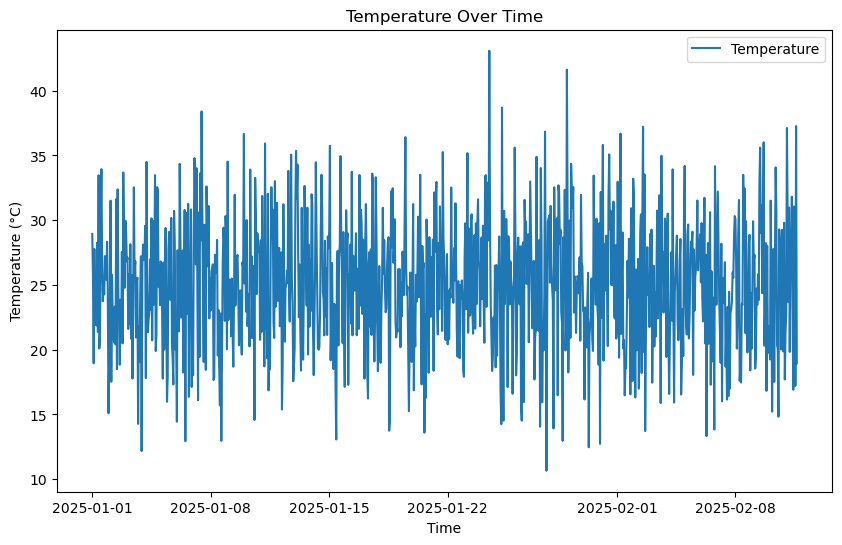

In [4]:
# Visualizing the temperature data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['temperature'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


In [5]:
# Feature Engineering: Rolling Mean, Std, Max for each sensor
df['temp_rolling_mean'] = df['temperature'].rolling(window=10).mean()
df['pressure_rolling_mean'] = df['pressure'].rolling(window=10).mean()
df['humidity_rolling_mean'] = df['humidity'].rolling(window=10).mean()
df['vibration_rolling_mean'] = df['vibration'].rolling(window=10).mean()

df['temp_rolling_std'] = df['temperature'].rolling(window=10).std()
df['pressure_rolling_std'] = df['pressure'].rolling(window=10).std()
df['humidity_rolling_std'] = df['humidity'].rolling(window=10).std()
df['vibration_rolling_std'] = df['vibration'].rolling(window=10).std()

df['temp_rolling_max'] = df['temperature'].rolling(window=10).max()


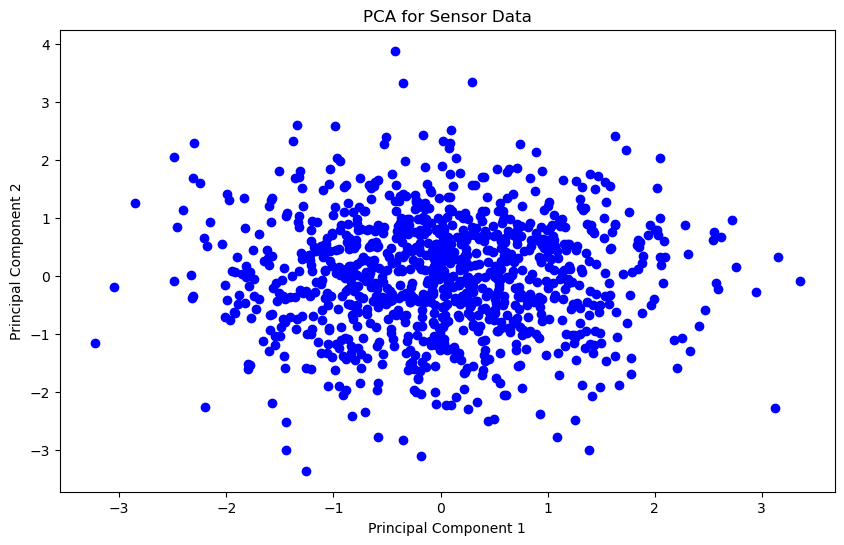

In [6]:
# Scaling the features for anomaly detection
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['temperature', 'pressure', 'humidity', 'vibration']])

# Applying PCA for dimensionality reduction (2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)

# Plotting PCA components
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c='blue', label='Sensor Data')
plt.title('PCA for Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


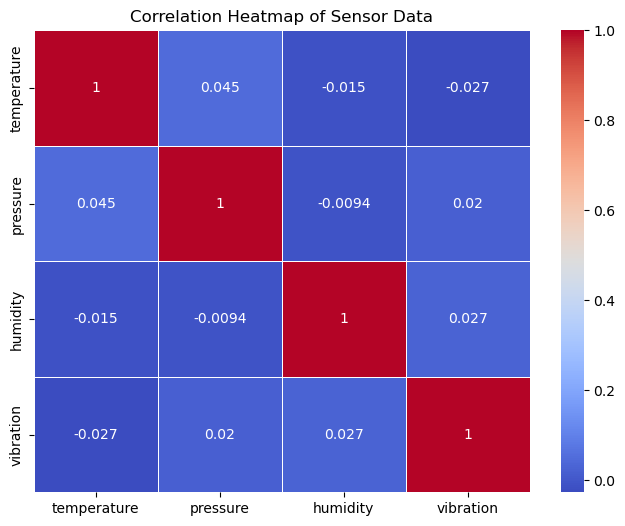

In [7]:
# Correlation Matrix & Heatmap
correlation_matrix = df[['temperature', 'pressure', 'humidity', 'vibration']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Sensor Data')
plt.show()


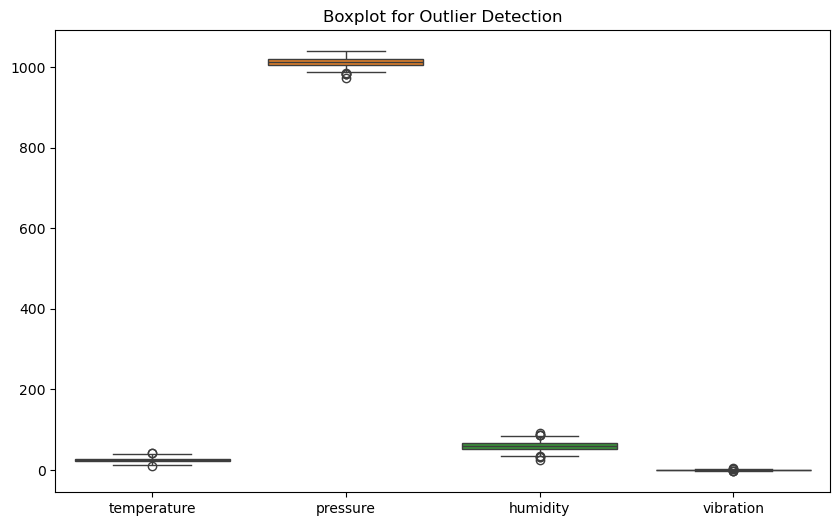

In [8]:
# Outlier Detection: Z-Score Method
z_scores = np.abs(zscore(df[['temperature', 'pressure', 'humidity', 'vibration']]))
outliers = (z_scores > 3).any(axis=1)

# Boxplot for detecting outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['temperature', 'pressure', 'humidity', 'vibration']])
plt.title('Boxplot for Outlier Detection')
plt.show()


In [12]:
# Anomaly Detection using One-Class SVM
svm_model = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
svm_pred = svm_model.fit_predict(df_scaled)

# Anomaly Detection using DBSCAN
dbscan_model = DBSCAN(eps=0.3, min_samples=10)
dbscan_pred = dbscan_model.fit_predict(df_scaled)

# Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.1)
iso_pred = iso_forest.fit_predict(df_scaled)

# Ground truth for anomaly detection (1 = Anomaly, 0 = Normal)
y_true = np.random.choice([0, 1], size=n, p=[0.9, 0.1])

# Model Evaluation with zero_division to avoid undefined precision/recall warnings
print("One-Class SVM Evaluation:")
print(classification_report(y_true, svm_pred, zero_division=1))

print("\nDBSCAN Evaluation:")
print(classification_report(y_true, dbscan_pred, zero_division=1))

print("\nIsolation Forest Evaluation:")
print(classification_report(y_true, iso_pred, zero_division=1))


One-Class SVM Evaluation:
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00         0
           0       1.00      0.00      0.00       908
           1       0.10      0.96      0.18        92

    accuracy                           0.09      1000
   macro avg       0.37      0.65      0.06      1000
weighted avg       0.92      0.09      0.02      1000


DBSCAN Evaluation:
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00       0.0
           0       1.00      0.00      0.00     908.0
           1       1.00      0.00      0.00      92.0

    accuracy                           0.00    1000.0
   macro avg       0.67      0.33      0.00    1000.0
weighted avg       1.00      0.00      0.00    1000.0


Isolation Forest Evaluation:
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00         0
           0       1.00      0.00      0.00       908

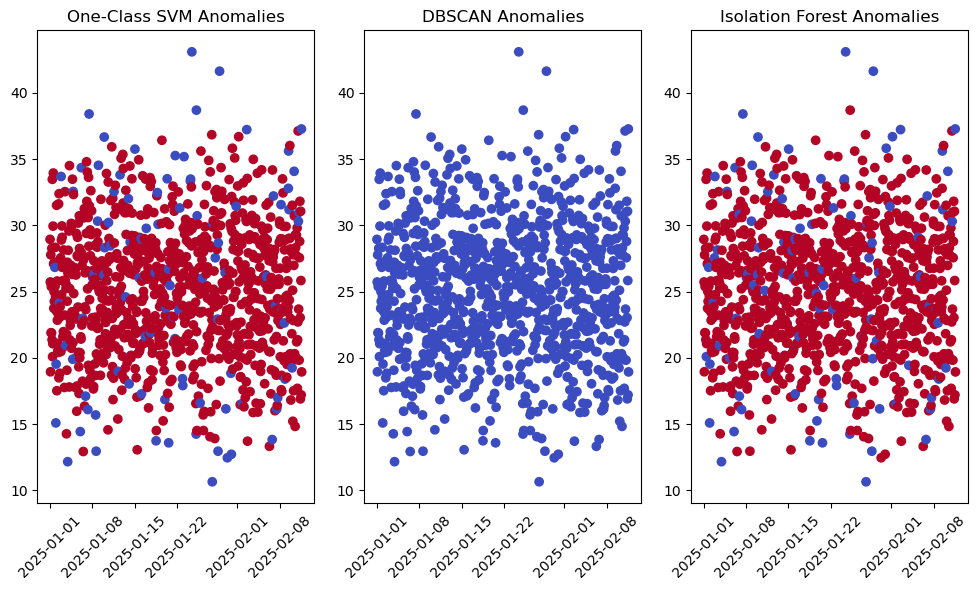

In [16]:
# Visualizing Anomaly Detection
plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.scatter(df.index, df['temperature'], c=svm_pred, cmap='coolwarm', label='SVM Anomalies')
plt.title('One-Class SVM Anomalies')
plt.xticks(rotation=45)
plt.subplot(132)
plt.scatter(df.index, df['temperature'], c=dbscan_pred, cmap='coolwarm', label='DBSCAN Anomalies')
plt.title('DBSCAN Anomalies')
plt.xticks(rotation=45)
plt.subplot(133)
plt.scatter(df.index, df['temperature'], c=iso_pred, cmap='coolwarm', label='Isolation Forest Anomalies')
plt.title('Isolation Forest Anomalies')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


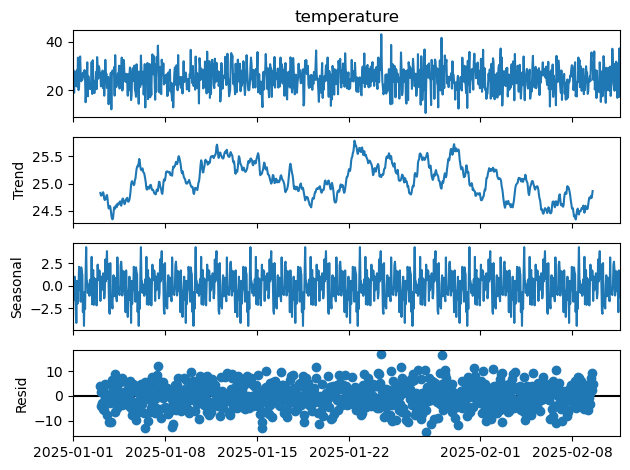

In [11]:
# Seasonality and Trend Decomposition (Seasonal Decompose)
result = seasonal_decompose(df['temperature'], model='additive', period=100)
result.plot()
plt.show()


In [ ]:
# Deploying Model as a REST API using Flask (commented out)
# from flask import Flask, request, jsonify
# app = Flask(__name__)
# @app.route('/predict', methods=['POST'])
# def predict():
#     data = request.get_json()
#     sensor_data = np.array(data['sensor_data']).reshape(1, -1)
#     prediction = svm_model.predict(sensor_data)  # Use the chosen anomaly detection model
#     return jsonify({'anomaly': prediction[0]})
# if __name__ == '__main__':
#     app.run(debug=True)
